<a href="https://colab.research.google.com/github/css-allyson/Gerador-Faces-Cachorros/blob/main/Faces_c%C3%A3es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install d2l==1.0.0-alpha1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 121 kB 29.7 MB/s 
     |████████████████████████████████| 1.6 MB 58.0 MB/s 
     |████████████████████████████████| 83 kB 2.7 MB/s 


Importação de pacotes

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from google.colab import files

Importação google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importação do dataset, redimensionamento das imagens e definição de batch size

In [ ]:
data_dir = "/content/drive/MyDrive/BTI/Aprendizado profundo/dog"
batch_size = 256
animais = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,label_mode=None, batch_size=batch_size, image_size=(64, 64),shuffle = True)

Found 4739 files belonging to 1 classes.


Reescalar imagens para intervalo [0-1] Normalização

In [ ]:
# For TF>=2.4 use `num_parallel_calls = tf.data.AUTOTUNE`
dataset = animais.map(lambda x: x / 255.0)
dataset = dataset.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

Preview de imagem aleatória do dataset

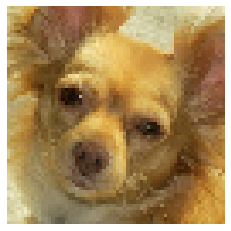

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Criação do discriminator

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

Criação do generator

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

Sobreposição train_step

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Callback para salvar e fazer download das imagens

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
            files.download("generated_img_%03d_%d.png" % (epoch, i))

Treino do modelo, loss function, optimizer e learning rate

In [ ]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/100
 6/19 [========>.....................] - ETA: 34s - d_loss: 0.6847 - g_loss: 0.8012

19/19 [==============================] - ETA: 0s - d_loss: 0.6640 - g_loss: 0.8094

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 85s 3s/step - d_loss: 0.6640 - g_loss: 0.8094
Epoch 2/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5862 - g_loss: 0.7608

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5862 - g_loss: 0.7608
Epoch 3/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4838 - g_loss: 1.1491

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4838 - g_loss: 1.1491
Epoch 4/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4987 - g_loss: 1.2094

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4987 - g_loss: 1.2094
Epoch 5/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5580 - g_loss: 1.3280

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5580 - g_loss: 1.3280
Epoch 6/100
19/19 [==============================] - ETA: 0s - d_loss: 0.1434 - g_loss: 3.5246

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.1434 - g_loss: 3.5246
Epoch 7/100
19/19 [==============================] - ETA: 0s - d_loss: 1.4917 - g_loss: 0.9119

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 1.4917 - g_loss: 0.9119
Epoch 8/100
19/19 [==============================] - ETA: 0s - d_loss: 0.3692 - g_loss: 1.6742

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.3692 - g_loss: 1.6742
Epoch 9/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8199 - g_loss: 0.8149

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8199 - g_loss: 0.8149
Epoch 10/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4743 - g_loss: 1.2962

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.4743 - g_loss: 1.2962
Epoch 11/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8763 - g_loss: 0.8607

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8763 - g_loss: 0.8607
Epoch 12/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7688 - g_loss: 0.8608

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.7688 - g_loss: 0.8608
Epoch 13/100
19/19 [==============================] - ETA: 0s - d_loss: 0.3861 - g_loss: 1.4301

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.3861 - g_loss: 1.4301
Epoch 14/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6455 - g_loss: 1.5344

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6455 - g_loss: 1.5344
Epoch 15/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5904 - g_loss: 1.2819

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5904 - g_loss: 1.2819
Epoch 16/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4582 - g_loss: 1.5549

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4582 - g_loss: 1.5549
Epoch 17/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5664 - g_loss: 1.6145

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5664 - g_loss: 1.6145
Epoch 18/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4954 - g_loss: 1.5908

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4954 - g_loss: 1.5908
Epoch 19/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6853 - g_loss: 1.0085

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.6853 - g_loss: 1.0085
Epoch 20/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4196 - g_loss: 1.4175

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4196 - g_loss: 1.4175
Epoch 21/100
19/19 [==============================] - ETA: 0s - d_loss: 0.9908 - g_loss: 0.6432

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.9908 - g_loss: 0.6432
Epoch 22/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8415 - g_loss: 0.7601

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8415 - g_loss: 0.7601
Epoch 23/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7416 - g_loss: 0.8713

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7416 - g_loss: 0.8713
Epoch 24/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5863 - g_loss: 1.0278

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.5863 - g_loss: 1.0278
Epoch 25/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5520 - g_loss: 1.0371

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5520 - g_loss: 1.0371
Epoch 26/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7237 - g_loss: 0.6632

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7237 - g_loss: 0.6632
Epoch 27/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5556 - g_loss: 0.8474

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5556 - g_loss: 0.8474
Epoch 28/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5926 - g_loss: 0.9211

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5926 - g_loss: 0.9211
Epoch 29/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7190 - g_loss: 0.8342

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7190 - g_loss: 0.8342
Epoch 30/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6219 - g_loss: 0.9617

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6219 - g_loss: 0.9617
Epoch 31/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5586 - g_loss: 1.0842

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5586 - g_loss: 1.0842
Epoch 32/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6973 - g_loss: 0.8555

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6973 - g_loss: 0.8555
Epoch 33/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5322 - g_loss: 1.1404

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5322 - g_loss: 1.1404
Epoch 34/100
19/19 [==============================] - ETA: 0s - d_loss: 0.9529 - g_loss: 0.7282

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.9529 - g_loss: 0.7282
Epoch 35/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7781 - g_loss: 0.8986

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.7781 - g_loss: 0.8986
Epoch 36/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7063 - g_loss: 1.0079

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7063 - g_loss: 1.0079
Epoch 37/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5473 - g_loss: 1.1902

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5473 - g_loss: 1.1902
Epoch 38/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4681 - g_loss: 1.2943

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4681 - g_loss: 1.2943
Epoch 39/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7042 - g_loss: 0.8349

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7042 - g_loss: 0.8349
Epoch 40/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5987 - g_loss: 0.8231

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5987 - g_loss: 0.8231
Epoch 41/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7806 - g_loss: 0.7207

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7806 - g_loss: 0.7207
Epoch 42/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8227 - g_loss: 0.6611

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8227 - g_loss: 0.6611
Epoch 43/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5906 - g_loss: 0.9972

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5906 - g_loss: 0.9972
Epoch 44/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6518 - g_loss: 1.0486

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6518 - g_loss: 1.0486
Epoch 45/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5459 - g_loss: 1.3304

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5459 - g_loss: 1.3304
Epoch 46/100
19/19 [==============================] - ETA: 0s - d_loss: 0.3890 - g_loss: 1.6310

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.3890 - g_loss: 1.6310
Epoch 47/100
19/19 [==============================] - ETA: 0s - d_loss: 1.0760 - g_loss: 0.6370

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 1.0760 - g_loss: 0.6370
Epoch 48/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4388 - g_loss: 1.7590

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4388 - g_loss: 1.7590
Epoch 49/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8804 - g_loss: 1.1289

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8804 - g_loss: 1.1289
Epoch 50/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8871 - g_loss: 1.0078

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8871 - g_loss: 1.0078
Epoch 51/100
19/19 [==============================] - ETA: 0s - d_loss: 0.2431 - g_loss: 2.8572

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.2431 - g_loss: 2.8572
Epoch 52/100
19/19 [==============================] - ETA: 0s - d_loss: 0.9304 - g_loss: 0.9328

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.9304 - g_loss: 0.9328
Epoch 53/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8449 - g_loss: 0.6380

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8449 - g_loss: 0.6380
Epoch 54/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5268 - g_loss: 0.8717

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5268 - g_loss: 0.8717
Epoch 55/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5336 - g_loss: 0.8428

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5336 - g_loss: 0.8428
Epoch 56/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4915 - g_loss: 0.9442

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4915 - g_loss: 0.9442
Epoch 57/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4178 - g_loss: 1.2642

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4178 - g_loss: 1.2642
Epoch 58/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5361 - g_loss: 1.2605

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.5361 - g_loss: 1.2605
Epoch 59/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6310 - g_loss: 1.4375

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6310 - g_loss: 1.4375
Epoch 60/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6424 - g_loss: 1.2013

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6424 - g_loss: 1.2013
Epoch 61/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6784 - g_loss: 1.1074

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6784 - g_loss: 1.1074
Epoch 62/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8335 - g_loss: 0.8502

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8335 - g_loss: 0.8502
Epoch 63/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6213 - g_loss: 1.0428

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6213 - g_loss: 1.0428
Epoch 64/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6357 - g_loss: 0.9474

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6357 - g_loss: 0.9474
Epoch 65/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7973 - g_loss: 0.5676

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7973 - g_loss: 0.5676
Epoch 66/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4709 - g_loss: 1.2071

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4709 - g_loss: 1.2071
Epoch 67/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6157 - g_loss: 1.0749

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6157 - g_loss: 1.0749
Epoch 68/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5921 - g_loss: 1.1722

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5921 - g_loss: 1.1722
Epoch 69/100
19/19 [==============================] - ETA: 0s - d_loss: 0.3862 - g_loss: 1.5606

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.3862 - g_loss: 1.5606
Epoch 70/100
19/19 [==============================] - ETA: 0s - d_loss: 0.2473 - g_loss: 2.1040

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.2473 - g_loss: 2.1040
Epoch 71/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6979 - g_loss: 1.4306

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6979 - g_loss: 1.4306
Epoch 72/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4895 - g_loss: 1.4934

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4895 - g_loss: 1.4934
Epoch 73/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5063 - g_loss: 1.4416

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5063 - g_loss: 1.4416
Epoch 74/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7545 - g_loss: 1.2128

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7545 - g_loss: 1.2128
Epoch 75/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7198 - g_loss: 1.1231

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 51s 3s/step - d_loss: 0.7198 - g_loss: 1.1231
Epoch 76/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5367 - g_loss: 1.3216

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5367 - g_loss: 1.3216
Epoch 77/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6999 - g_loss: 0.9701

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6999 - g_loss: 0.9701
Epoch 78/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5211 - g_loss: 1.1893

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5211 - g_loss: 1.1893
Epoch 79/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4660 - g_loss: 1.5055

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4660 - g_loss: 1.5055
Epoch 80/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7716 - g_loss: 1.6514

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7716 - g_loss: 1.6514
Epoch 81/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5835 - g_loss: 2.0998

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5835 - g_loss: 2.0998
Epoch 82/100
19/19 [==============================] - ETA: 0s - d_loss: 0.8740 - g_loss: 1.1191

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.8740 - g_loss: 1.1191
Epoch 83/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7564 - g_loss: 0.9122

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7564 - g_loss: 0.9122
Epoch 84/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6628 - g_loss: 1.0209

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6628 - g_loss: 1.0209
Epoch 85/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6013 - g_loss: 1.0769

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6013 - g_loss: 1.0769
Epoch 86/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5002 - g_loss: 1.2004

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5002 - g_loss: 1.2004
Epoch 87/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4766 - g_loss: 1.2292

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4766 - g_loss: 1.2292
Epoch 88/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7003 - g_loss: 0.8161

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7003 - g_loss: 0.8161
Epoch 89/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6597 - g_loss: 0.6951

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6597 - g_loss: 0.6951
Epoch 90/100
19/19 [==============================] - ETA: 0s - d_loss: 0.4719 - g_loss: 0.9832

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.4719 - g_loss: 0.9832
Epoch 91/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6547 - g_loss: 0.9654

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6547 - g_loss: 0.9654
Epoch 92/100
19/19 [==============================] - ETA: 0s - d_loss: 0.7464 - g_loss: 0.7959

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.7464 - g_loss: 0.7959
Epoch 93/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6017 - g_loss: 0.9118

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6017 - g_loss: 0.9118
Epoch 94/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5006 - g_loss: 1.1052

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5006 - g_loss: 1.1052
Epoch 95/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5569 - g_loss: 1.0819

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5569 - g_loss: 1.0819
Epoch 96/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6284 - g_loss: 0.9301

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 49s 3s/step - d_loss: 0.6284 - g_loss: 0.9301
Epoch 97/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6413 - g_loss: 1.1088

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6413 - g_loss: 1.1088
Epoch 98/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5435 - g_loss: 1.2935

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5435 - g_loss: 1.2935
Epoch 99/100
19/19 [==============================] - ETA: 0s - d_loss: 0.6554 - g_loss: 1.1862

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.6554 - g_loss: 1.1862
Epoch 100/100
19/19 [==============================] - ETA: 0s - d_loss: 0.5881 - g_loss: 1.1811

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19/19 [==============================] - 50s 3s/step - d_loss: 0.5881 - g_loss: 1.1811


Dowload das imagens caso não sejam baixadas automaticamente

In [ ]:
for i in range(80,99):
  files.download("generated_img_J_%03d_0.png" % (i))

FileNotFoundError: ignored

fonte: https://keras.io/examples/generative/dcgan_overriding_train_step/